<a href="https://colab.research.google.com/github/nicolas1805961/GE_reinforcement_learning/blob/master/fork_of_ge_deep_q_learning_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [116]:
#import glob
#import pydicom
#import numpy as np
#import matplotlib.pyplot as plt

#patient_path = glob.glob('/kaggle/input/ge-dqn/Patients/*')[0]
#files = []
#for slice_path in glob.glob(patient_path + '/*'):
#    files.append(pydicom.dcmread(slice_path))
#files = sorted(files, key=lambda s: s.SliceLocation)
#shape = files[0].pixel_array.shape
#shape = list(shape)
#shape.insert(0, len(files))
#img3d = np.zeros(shape)
#for i, s in enumerate(files):
#    img2d = s.pixel_array
#    img3d[i, :, :] = img2d
#print(img3d.shape)
#img = np.max(img3d, axis=0).T
#img = np.rot90(img, 2)
        
#plt.imshow(img3d[:, shape[1] // 2, :], cmap='bone')

In [117]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [118]:
import math
import random
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [119]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [120]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
from numpy.random import randint, choice
from torchvision.transforms.functional import affine
from PIL import Image
from sklearn.model_selection import train_test_split

data_train = pd.read_csv("/content/drive/My Drive/fashion-mnist_train.csv")
data_train = data_train.iloc[:50, 1:].values
data_train = data_train.reshape((data_train.shape[0], 28, 28))
p = (50 - 28) // 2
data_train = np.pad(data_train, ((0, 0), (p, p), (p, p)), 'constant', constant_values=0)

In [121]:
data_test = pd.read_csv("/content/drive/My Drive/fashion-mnist_test.csv")
data_test = data_test.iloc[:50, 1:].values
data_test = data_test.reshape((data_test.shape[0], 28, 28))
p = (50 - 28) // 2
data_test = np.pad(data_test, ((0, 0), (p, p), (p, p)), 'constant', constant_values=0)

In [122]:
data = np.concatenate((data_train, data_test))

In [123]:
del data_train
del data_test

In [124]:
data = data.astype(np.uint8)
print(data.shape)

(100, 50, 50)


[ 0. -0.]
[ 0. -0.]
[0. 0.]
[ 1. -0.]


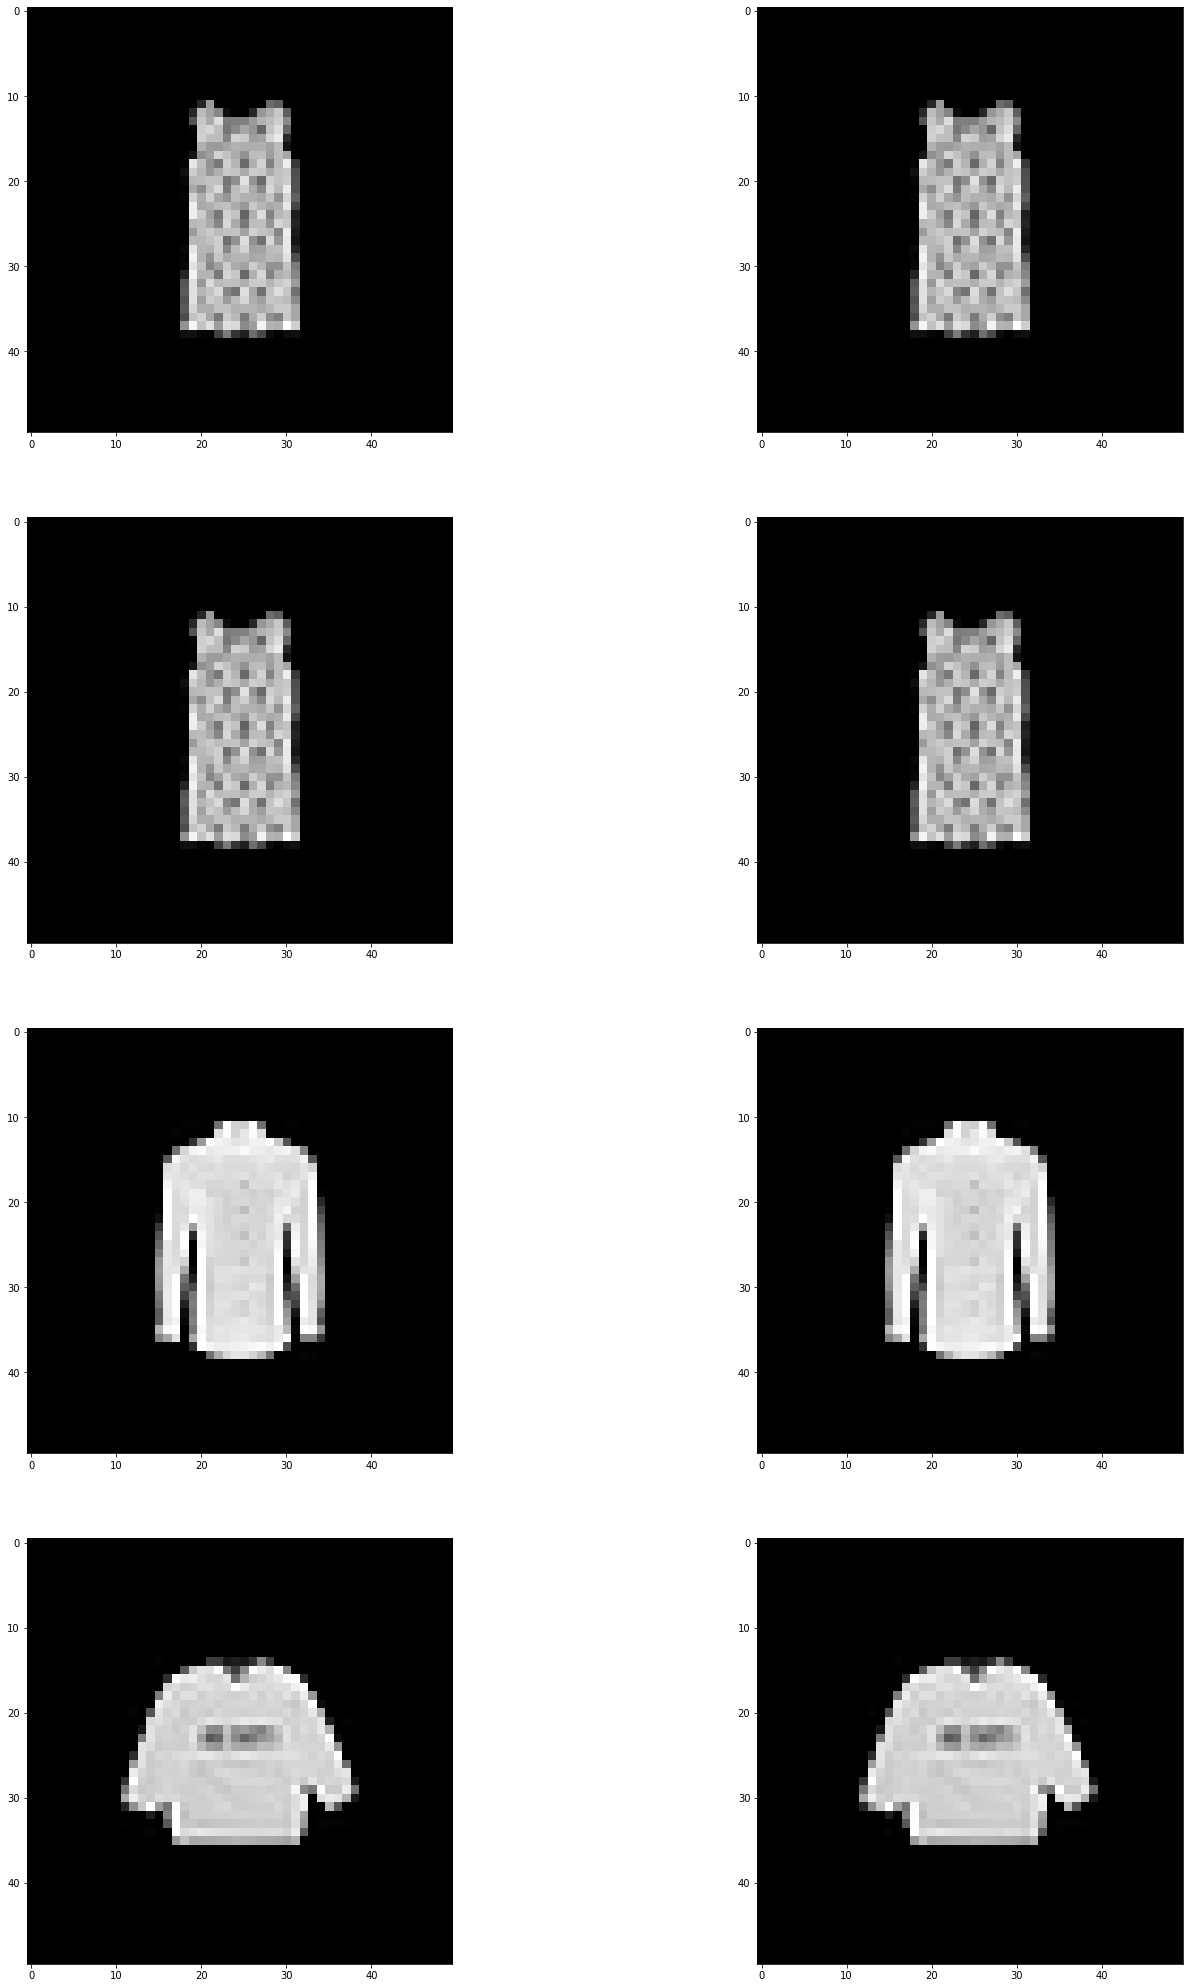

In [125]:
from skimage.measure import regionprops, label
from skimage.filters import threshold_otsu

image_center = np.array([25, 25])
offset = np.zeros((data.shape[0], 2))
test = data.copy()
for i in range(data.shape[0]):
  binary = (test[i, ...] > 20).astype(np.uint8)
  centroid = np.array(regionprops(binary)[0].centroid)
  offset[i] = np.rint(image_center - centroid)[::-1]
  im = Image.fromarray(test[i, ...].astype(np.uint8))
  data[i, ...] = np.array(affine(im, angle=0, translate=list(offset[i]), scale=1, shear=0))

fig, ax = plt.subplots(4, 2, figsize=(24, 9*4))
for i in range(4):
    n = randint(0, data.shape[0])
    print(offset[n])
    ax[i, 0].imshow(test[n,...], cmap='gray')
    ax[i, 1].imshow(data[n,...], cmap='gray')
  
del offset, test, image_center

In [126]:
from skimage.measure import label, regionprops, approximate_polygon, find_contours

def get_perimeter(image):
    img = image.copy()
    img[img > 0] = 255
    perimeter = 0
    contour = sorted(find_contours(img, 0), key=lambda x: x.shape[0])[-1]
    perimeter = approximate_polygon(contour, tolerance=0)
    return perimeter

In [127]:
def rotate_image(image, angle, image_center):
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

In [128]:
def translate_image(image, x, y):
    translation_matrix = np.float32([ [1,0,x], [0,1,y] ])
    img_translation = cv2.warpAffine(image, translation_matrix, image.shape[1::-1])
    return img_translation

In [129]:
from numpy.random import choice

def get_rotation_number(r1=None):
    r = 0
    if r1 is not None:
      while r == 0 or abs(r1 - r) > 50 or abs(r1 - r) == 0:
        r = choice(np.arange(start=-50, stop=51, step=10))
    else:
      while r == 0:
        r = choice(np.arange(start=-50, stop=51, step=10))
    return r

In [130]:
from numpy.random import choice

def get_rotation_number2(t=None, r1=None):
    r = 0
    if r1 is not None and t is not None:
      r = r1 - t
    else:
      while abs(r) < 10:
        r = np.random.randint(-50, 50)
    return r

In [131]:
from numpy.random import choice
'''
repeat = choice([1, 2], size=data.shape[0], p=[1, 0])
number_of_images = repeat.sum()
print('number of images = {}'.format(number_of_images))
root_images = np.zeros((number_of_images, data.shape[1], data.shape[2]))
first_images = np.zeros((number_of_images, data.shape[1], data.shape[2]))
second_images = np.zeros((number_of_images, data.shape[1], data.shape[2]))
Y = torch.zeros((number_of_images, 3), dtype=torch.int16)
second_translation = torch.zeros((number_of_images, 2), dtype=torch.int16)
count = 0
for i, j in zip(range(data.shape[0]), repeat):
    im = Image.fromarray(data[i, ...].astype(np.uint8))
    for t in range(j):
        #numbers = [randint(-10, 10), randint(-10, 10)]
        numbers = [0, 0]
        r1 = get_rotation_number()
        one = affine(im, angle=r1, translate=numbers, scale=1, shear=0)
        #one = affine(im, angle=0, translate=numbers, scale=1, shear=0)
        #rotated = rotate_image(data[i, ...], numbers[0], (25, 25))
        #translated = translate_image(rotated, numbers[1], numbers[2])

        #numbers2 = [randint(-10, 10), randint(-10, 10)]
        numbers2 = [0, 0]
        r2 = get_rotation_number(r1)
        two = affine(im, angle=r2, translate=numbers2, scale=1, shear=0)
        #two = affine(im, angle=0, translate=numbers2, scale=1, shear=0)
        #rotated2 = rotate_image(data[i, ...], numbers2[0], (25, 25))
        #translated2 = translate_image(rotated2, numbers2[1], numbers2[2])
        
        second_images[count, ...] = two
        second_translation[count] = torch.tensor([numbers2[0], numbers2[1]])
        first_images[count, ...] = one
        root_images[count, ...] = data[i, ...]
        Y[count] = torch.tensor([r1 - r2, numbers[0] - numbers2[0], numbers[1] - numbers2[1]])
        #Y[count] = torch.tensor([0, numbers[0] - numbers2[0], numbers[1] - numbers2[1]])
        count += 1
        
del data

fig, ax = plt.subplots(4, 2, figsize=(24, 9*4))
for i in range(4):
    n = randint(0, number_of_images)
    print(Y[n])
    ax[i, 0].imshow(first_images[n,...], cmap='gray')
    ax[i, 1].imshow(second_images[n,...], cmap='gray')'''

"\nrepeat = choice([1, 2], size=data.shape[0], p=[1, 0])\nnumber_of_images = repeat.sum()\nprint('number of images = {}'.format(number_of_images))\nroot_images = np.zeros((number_of_images, data.shape[1], data.shape[2]))\nfirst_images = np.zeros((number_of_images, data.shape[1], data.shape[2]))\nsecond_images = np.zeros((number_of_images, data.shape[1], data.shape[2]))\nY = torch.zeros((number_of_images, 3), dtype=torch.int16)\nsecond_translation = torch.zeros((number_of_images, 2), dtype=torch.int16)\ncount = 0\nfor i, j in zip(range(data.shape[0]), repeat):\n    im = Image.fromarray(data[i, ...].astype(np.uint8))\n    for t in range(j):\n        #numbers = [randint(-10, 10), randint(-10, 10)]\n        numbers = [0, 0]\n        r1 = get_rotation_number()\n        one = affine(im, angle=r1, translate=numbers, scale=1, shear=0)\n        #one = affine(im, angle=0, translate=numbers, scale=1, shear=0)\n        #rotated = rotate_image(data[i, ...], numbers[0], (25, 25))\n        #translate

number of images = 1000
1000
tensor([40,  0,  0], dtype=torch.int16)
tensor([50,  0,  0], dtype=torch.int16)
tensor([-30,   0,   0], dtype=torch.int16)
tensor([10,  0,  0], dtype=torch.int16)


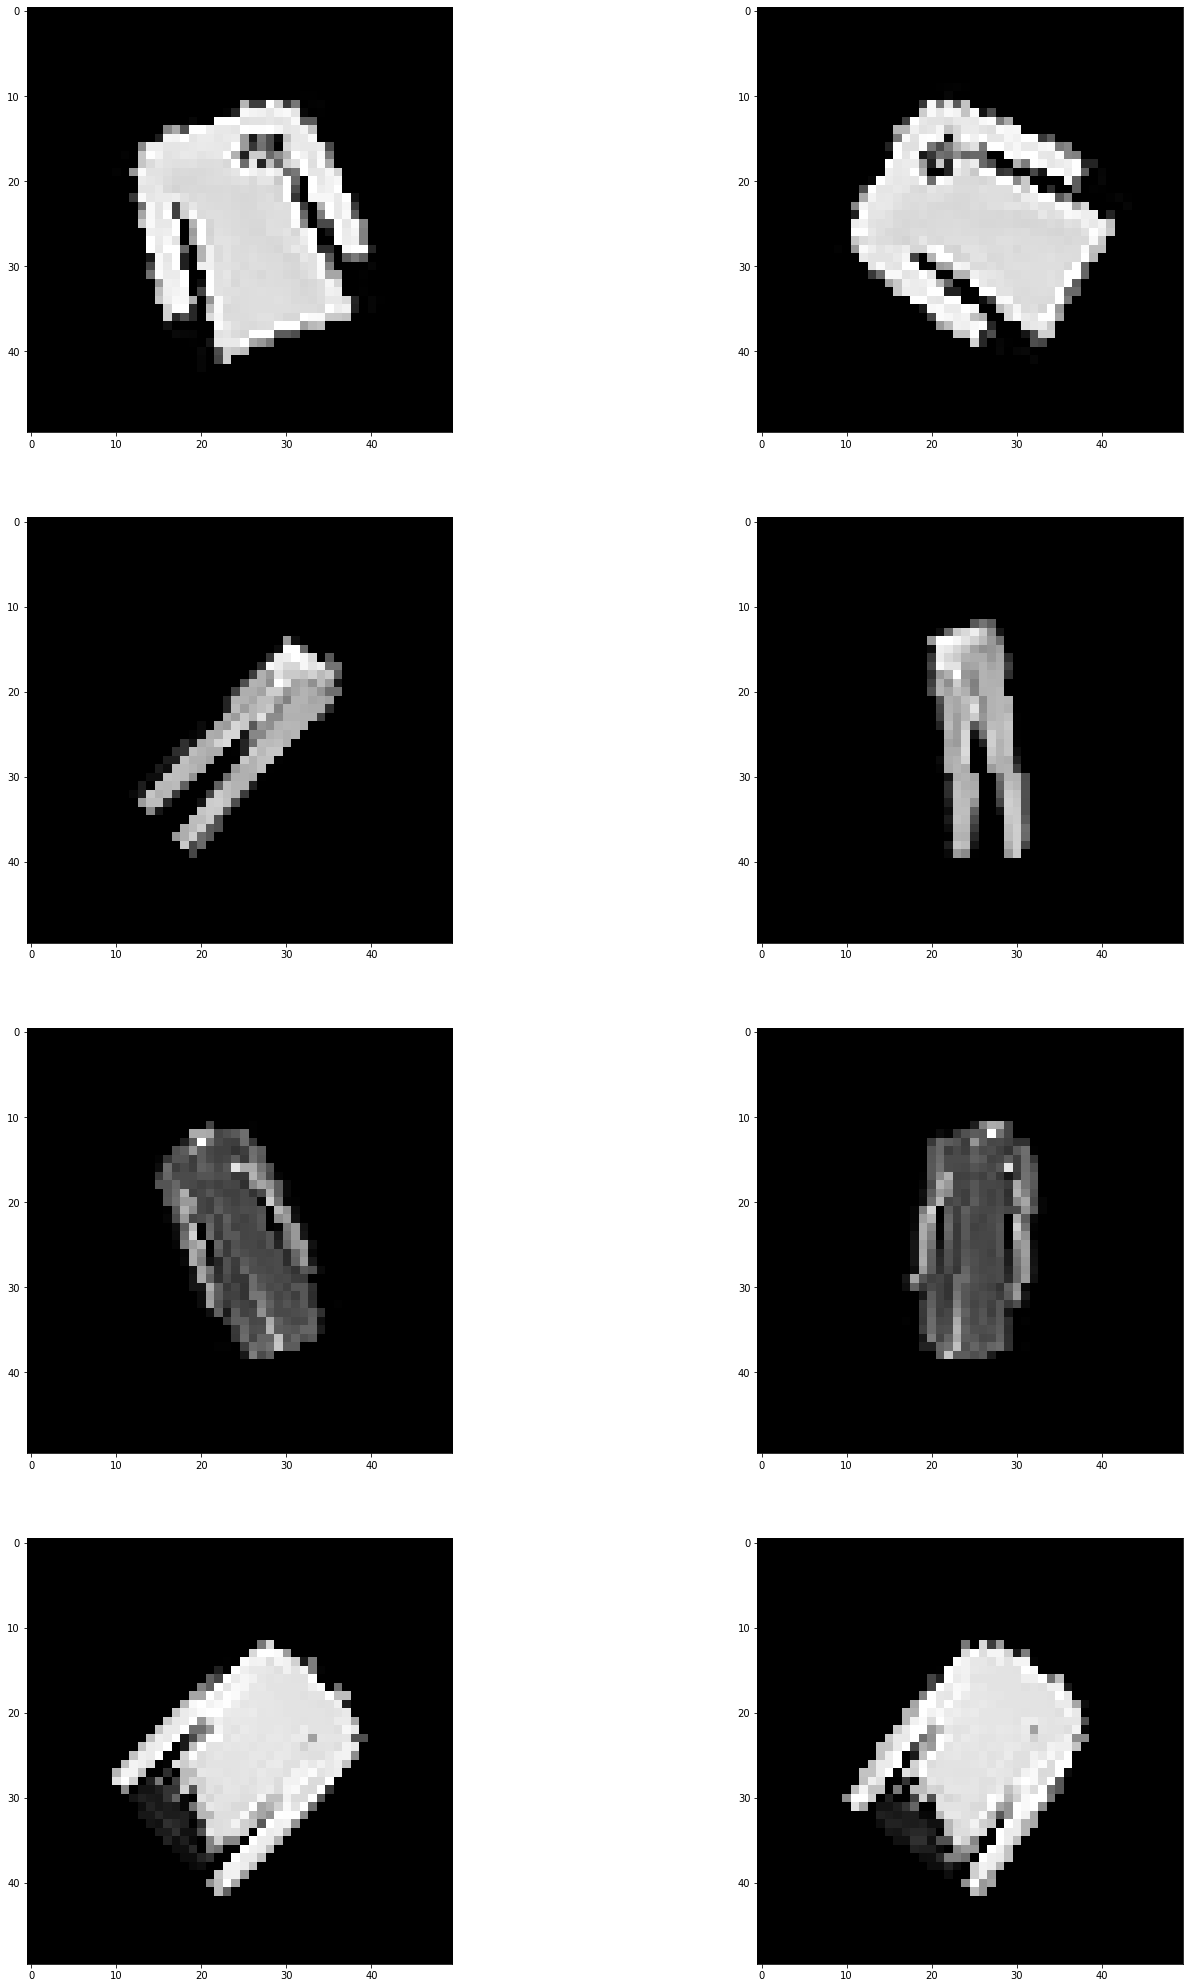

In [132]:
#repeat = choice([1, 2], size=data.shape[0], p=[1, 0])
number_of_images = 1000
print('number of images = {}'.format(number_of_images))
root_images = np.zeros((number_of_images, data.shape[1], data.shape[2]))
first_images = np.zeros((number_of_images, data.shape[1], data.shape[2]))
second_images = np.zeros((number_of_images, data.shape[1], data.shape[2]))
Y = torch.zeros((number_of_images, 3), dtype=torch.int16)
second_translation = torch.zeros((number_of_images, 2), dtype=torch.int16)
count = 0
for i in range(data.shape[0]):
    im = Image.fromarray(data[i, ...].astype(np.uint8))
    for t in range(-50, 51, 10):
      if t == 0:
        continue
      #numbers = [randint(-10, 10), randint(-10, 10)]
      numbers = [0, 0]
      r1 = get_rotation_number2()
      one = affine(im, angle=r1, translate=numbers, scale=1, shear=0)
      #one = affine(im, angle=0, translate=numbers, scale=1, shear=0)
      #rotated = rotate_image(data[i, ...], numbers[0], (25, 25))
      #translated = translate_image(rotated, numbers[1], numbers[2])

      #numbers2 = [randint(-10, 10), randint(-10, 10)]
      numbers2 = [0, 0]
      r2 = get_rotation_number2(t, r1)
      two = affine(im, angle=r2, translate=numbers2, scale=1, shear=0)
      #two = affine(im, angle=0, translate=numbers2, scale=1, shear=0)
      #rotated2 = rotate_image(data[i, ...], numbers2[0], (25, 25))
      #translated2 = translate_image(rotated2, numbers2[1], numbers2[2])
      
      second_images[count, ...] = two
      second_translation[count] = torch.tensor([numbers2[0], numbers2[1]])
      first_images[count, ...] = one
      root_images[count, ...] = data[i, ...]
      Y[count] = torch.tensor([r1 - r2, numbers[0] - numbers2[0], numbers[1] - numbers2[1]])
      #Y[count] = torch.tensor([0, numbers[0] - numbers2[0], numbers[1] - numbers2[1]])
      count += 1
        
del data
print(count)

fig, ax = plt.subplots(4, 2, figsize=(24, 9*4))
for i in range(4):
    n = randint(0, number_of_images)
    print(Y[n])
    ax[i, 0].imshow(first_images[n,...], cmap='gray')
    ax[i, 1].imshow(second_images[n,...], cmap='gray')

In [133]:
from math import cos, sin

class Q_value():
    def __init__(self, gamma, epsilon, R, number_of_outputs):
        self.Tg = None
        self.gamma = gamma
        self.epsilon = epsilon
        self.R = R
        self.number_of_outputs = number_of_outputs

    def get_matrix_from_tensor(self, Tt):
        if self.number_of_outputs == 12:
            A = torch.tensor([[1, 0, 0, Tt[0]],
                            [0, cos(Tt[3]), -sin(Tt[3]), Tt[1]],
                            [0, sin(Tt[3]), cos(Tt[3]), Tt[2]],
                            [0, 0, 0, 1]])

            B = torch.tensor([[cos(Tt[4]), 0, sin(Tt[4]), 0],
                            [0, 0, 0, 0],
                            [-sin(Tt[4]), 0, cos(Tt[4]), 0],
                            [0, 0, 0, 1]])

            C = torch.tensor([[cos(Tt[5]), -sin(Tt[5]), 0, 0],
                            [sin(Tt[5]), cos(Tt[5]), 0, 0],
                            [0, 0, 1, 0],
                            [0, 0, 0, 1]])

            D = torch.matmul(A, B)
            return torch.matmul(D, C)
        
        elif self.number_of_outputs == 6:

            A = torch.tensor([[1, 0, 0, Tt[1]],
                            [0, cos(Tt[0]), -sin(Tt[0]), Tt[2]],
                            [0, sin(Tt[0]), cos(Tt[0]), 0],
                            [0, 0, 0, 1]])
            
            return A
            

    def get_optimal_action(self, Tt):
        at = torch.cat((torch.eye(self.number_of_outputs // 2), torch.eye(self.number_of_outputs // 2) * -1))
        at = at
        at_o_Tt = at + Tt.view((1, 3))
        norms = [self.get_distance(at_o_Tt[i, :]) for i in range(self.number_of_outputs)]
        return np.argmin(np.asarray(norms))
    
    def get_distance(self, x):
        if self.number_of_outputs == 4 or self.number_of_outputs == 6:
            inversed = x * -1
            composed = self.Tg + inversed
        else:
            matrice = self.get_matrix_from_tensor(x)
            inversed = torch.inverse(matrice)
            Tg_matrix = self.get_matrix_from_tensor(self.Tg)
            composed = torch.matmul(Tg_matrix, inversed)
            print(composed)
        composed = composed.float()
        norm = torch.norm(composed).item()
        return norm
    
    def set_Tg(self, Tg):
        self.Tg = Tg

    def take_action(self, action, Tt):
        current_Tt = Tt.clone()
        if action < self.number_of_outputs // 2:
            current_Tt[action] +=1
            return current_Tt
        else:
            current_Tt[action - (self.number_of_outputs // 2)] -=1
            return current_Tt
    
    def get_reward(self, Tt, Tt_next):
        return self.get_distance(Tt) - self.get_distance(Tt_next)

    def get_q_value(self, Tt, action):
        Tt_next = self.take_action(action, Tt)
        reward = self.get_reward(Tt, Tt_next)
        #print(self.get_distance(Tt_next))
        if self.get_distance(Tt_next) < self.epsilon:
            return reward + self.R
        optimal_action_next = self.get_optimal_action(Tt_next)
        return reward + self.gamma * self.get_q_value(Tt_next, optimal_action_next)

In [134]:
class Dataset_train(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X, Q, transform):
        'Initialization'
        self.X = X
        self.Q = Q
        self.transform = transform

  def __len__(self):
        'Denotes the total number of samples'
        return self.X.shape[0]

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        X = self.X[index]
        #X = self.transform(X)

        # Load data and get label
        Q = self.Q[index]

        return X, Q

In [135]:
class Dataset_test(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X, Y, first_images, root_image, second_translation, transform):
        'Initialization'
        self.X = X
        self.Y = Y
        self.first_images = first_images
        #self.second_images = second_images
        self.root = root_image
        self.second_translation = second_translation
        self.transform = transform

  def __len__(self):
        'Denotes the total number of samples'
        return self.X.shape[0]

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        X = self.X[index]
        #X = self.transform(X)

        # Load data and get label
        Y = self.Y[index]
        
        one = self.first_images[index]
        #two = self.second_images[index]
        
        root_image = self.root[index]
        second_translation = self.second_translation[index]

        return X, Y, one, root_image, second_translation, index

In [136]:
import torchvision.transforms as transforms

X = first_images - second_images
del second_images
X = np.expand_dims(X, axis=(1))
X /= 255
#mean = X.mean()
#std = X.std()

transform = transforms.Compose(
    [transforms.Normalize((0.5), (0.5))])

all_indices = list(range(X.shape[0]))
print('ok1')

test_size_percent = 0.00001
test_size = test_size_percent * len(all_indices)
train_indices, test_indices = train_test_split(all_indices, test_size=test_size_percent, random_state=42)
del all_indices
X_train = torch.from_numpy(X[train_indices, ...])
X_test = torch.from_numpy(X[test_indices, ...])
del X
Y_train = Y[train_indices, ...]
Y_test = Y[test_indices, ...]
del Y
print('ok2')

dataset_test = Dataset_test(X_test, Y_test, first_images[test_indices, ...], root_images[test_indices, ...], second_translation[test_indices, ...], transform)
dataset_overfit = Dataset_test(X_train, Y_train, first_images[train_indices, ...], root_images[train_indices, ...], second_translation[train_indices, ...], transform)

del X_test, Y_test, test_indices, train_indices, first_images, root_images, second_translation

print('ok3')

subset_indices = list(range(20))
subset_overfit = torch.utils.data.Subset(dataset_overfit, subset_indices)
del subset_indices

testing_generator = torch.utils.data.DataLoader(dataset_test)
overfit_generator = torch.utils.data.DataLoader(subset_overfit)
del subset_overfit, dataset_test

ok1
ok2
ok3


In [137]:
q_value = Q_value(0.9, 0.5, 10, 6)
Tt = torch.zeros(3)
q_values = torch.zeros((X_train.shape[0], 6)).to(device)
for i in range(X_train.shape[0]):
    print(i)
    q_value.set_Tg(Y_train[i])
    row = []
    for t in range(6):
        row.append(q_value.get_q_value(Tt, t))
    q_values[i, :] = torch.tensor(row).reshape((1, -1))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [138]:
for i in range(30):
    print(Y_train[i])
    print(q_values[i, :])

tensor([30,  0,  0], dtype=torch.int16)
tensor([10.0471,  8.9673,  8.9673,  8.0382,  8.9673,  8.9673], device='cuda:0')
tensor([-50,   0,   0], dtype=torch.int16)
tensor([ 8.0046,  8.9858,  8.9858, 10.0057,  8.9858,  8.9858], device='cuda:0')
tensor([-50,   0,   0], dtype=torch.int16)
tensor([ 8.0046,  8.9858,  8.9858, 10.0057,  8.9858,  8.9858], device='cuda:0')
tensor([-40,   0,   0], dtype=torch.int16)
tensor([ 8.0133,  8.9796,  8.9796, 10.0164,  8.9796,  8.9796], device='cuda:0')
tensor([40,  0,  0], dtype=torch.int16)
tensor([10.0164,  8.9796,  8.9796,  8.0133,  8.9796,  8.9796], device='cuda:0')
tensor([20,  0,  0], dtype=torch.int16)
tensor([10.1351,  8.9422,  8.9422,  8.1094,  8.9422,  8.9422], device='cuda:0')
tensor([-20,   0,   0], dtype=torch.int16)
tensor([ 8.1094,  8.9422,  8.9422, 10.1351,  8.9422,  8.9422], device='cuda:0')
tensor([50,  0,  0], dtype=torch.int16)
tensor([10.0057,  8.9858,  8.9858,  8.0046,  8.9858,  8.9858], device='cuda:0')
tensor([20,  0,  0], dtype=t

In [139]:
dataset_train = Dataset_train(X_train, q_values, transform)
training_generator = torch.utils.data.DataLoader(dataset_train, 1)

In [140]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DQN(nn.Module):

    def __init__(self, d, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
        self.maxpool1 = nn.MaxPool2d(2)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 32, kernel_size=3)
        self.maxpool2 = nn.MaxPool2d(2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 128, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn5 = nn.BatchNorm2d(128)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(w, f=3, p=0, s=1):
            return ((w - f + 2*p) // s) + 1
        
        def maxpool_size_out(w):
            return w // 2
        
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(maxpool_size_out(conv2d_size_out(maxpool_size_out(conv2d_size_out(w)))))))
        linear_input_size = convw * convw * 128
        
        self.head1 = nn.Linear(linear_input_size, 512)
        self.head2 = nn.Linear(512, 512)
        self.head3 = nn.Linear(512, 64)
        self.head4 = nn.Linear(64, outputs)
        
        self.linear_input_size = linear_input_size

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.maxpool1(self.conv1(x))))
        x = F.relu(self.bn2(self.maxpool2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = x.view(-1, self.linear_input_size)
        x = F.relu(self.head1(x))
        x = F.relu(self.head2(x))
        x = F.relu(self.head3(x))
        return self.head4(x)

#for x, y in training_generator:
#    print(x.size())
 #   net = DQN(1, x.shape[2], x.shape[3], 4).float()
#    out = net(x.float())
#    print(out.max(1)[1])
#    print(torch.argmax(out, dim=1))
#    break

In [141]:
from itertools import count

policy_net = DQN(1, 50, 50, 6).to(device)
optimizer = optim.Adam(policy_net.parameters())
criterion = nn.MSELoss().to(device)
running_loss = 0.0
number_of_epoch = 2000

for i_episode in range(number_of_epoch):
    for index, data in enumerate(training_generator):
        x = data[0].to(device)
        q = data[1].to(device)

        optimizer.zero_grad()
        out = policy_net(x.float()).to(device)
        
        #loss = torch.norm(out - q, dim=1).sum()
        loss = criterion(out, q)

        loss.backward()
        #for param in policy_net.parameters():
         #   param.grad.data.clamp_(-1, 1)
        optimizer.step()
        
        running_loss += loss.item()
    # print statistics
    print("Epoch: {} Loss: {}".format((i_episode + 1), running_loss / (i_episode + 1)))


Epoch: 1 Loss: 1499.0889339828864
Epoch: 2 Loss: 924.6355310226791
Epoch: 3 Loss: 697.4603195271533
Epoch: 4 Loss: 572.2800813154608
Epoch: 5 Loss: 487.2905974496389
Epoch: 6 Loss: 423.6491885356566
Epoch: 7 Loss: 384.6737361576109
Epoch: 8 Loss: 347.90005868660955
Epoch: 9 Loss: 320.99809634480494
Epoch: 10 Loss: 294.6219061348587
Epoch: 11 Loss: 272.81418042492373
Epoch: 12 Loss: 257.1614119019844
Epoch: 13 Loss: 240.4735196209479
Epoch: 14 Loss: 227.61340649089107
Epoch: 15 Loss: 215.58683229340627
Epoch: 16 Loss: 206.03527564895649
Epoch: 17 Loss: 196.08439650738472
Epoch: 18 Loss: 187.36741017387612
Epoch: 19 Loss: 179.3467722209672
Epoch: 20 Loss: 172.92078758563693
Epoch: 21 Loss: 165.79888828823252
Epoch: 22 Loss: 159.8534070639547
Epoch: 23 Loss: 154.72034157653061
Epoch: 24 Loss: 149.43029250365012
Epoch: 25 Loss: 144.53703562955852
Epoch: 26 Loss: 140.06690012806283
Epoch: 27 Loss: 136.9162085953246
Epoch: 28 Loss: 133.71592200538913
Epoch: 29 Loss: 130.1655582486855
Epoch: 

In [142]:
from torchvision.transforms.functional import normalize, to_pil_image, to_tensor

correct = 0
total = 30
number_of_steps = 200
list_of_examples = []
perimeters = []
with torch.no_grad():
    for data in overfit_generator:
        list_of_frames = []
        print('***************************')
        x = data[0].to(device)
        y = data[1]
        first_image = data[2]
        #second_image = data[3].numpy()
        #second_image = to_pil_image(data[3].int())
        root_image = to_pil_image(data[3].int())
        second_translation = data[4]
        Tt = torch.zeros((number_of_steps, 3), dtype=torch.int16)
        print(y)
        print('/*/*/*/*/*/*/*/*/*/*/*/*/*/*')
        j = 0
        perimeters.append(get_perimeter(first_image[0, ...].numpy()))
        while j < number_of_steps - 1:
            out = policy_net(x.float())
            print(out)
            action = torch.argmax(out, dim=1)
            Tt[j + 1, :] = q_value.take_action(action, Tt[j, :])
            if j > 5 and torch.all(Tt[j + 1, :].eq(Tt[j - 1, :])):
                if torch.dist(Tt[j + 1, :].float(), y).item() <= 1:
                    correct += 1
                break
            translation = (Tt[j + 1, 1].item() + second_translation[0, 0].item(), Tt[j + 1, 2].item() + second_translation[0, 1].item())
            #translated = translate_image(second_image[0, ...], Tt_new[1].item(), Tt_new[2].item())
            #current_image = rotate_image(translated, Tt_new[0].item(), (second_position[0, 0] + Tt_new[1].item(), second_position[0, 1] + Tt_new[2].item()))
            current_image = to_tensor(affine(root_image, angle=Tt[j + 1, 0].item(), translate=translation, scale=1, shear=0))
            list_of_frames.append(current_image.numpy().reshape((50, 50)))
            diff = first_image - current_image
            diff /= 255
            x = diff.unsqueeze(0).to(device)
            j += 1
        stack_of_frames = np.stack(list_of_frames)
        #stack_of_frames = np.pad(stack_of_frames, ((0, number_of_steps - stack_of_frames.shape[0]), (0, 0), (0, 0)))
        list_of_examples.append(stack_of_frames)
        mask = Tt.eq(torch.zeros((number_of_steps, 3))).all(dim=1)[5:]
        Tt = torch.cat((Tt[:5], Tt[5:][~mask]))
        print(Tt)
    print('accuracy {}%'.format(100 * correct / total))

***************************
tensor([[30,  0,  0]], dtype=torch.int16)
/*/*/*/*/*/*/*/*/*/*/*/*/*/*
tensor([[10.0437,  8.9694,  8.9694,  8.0345,  8.9694,  8.9695]],
       device='cuda:0')
tensor([[10.1672,  8.9347,  8.9347,  8.1268,  8.9347,  8.9347]],
       device='cuda:0')
tensor([[10.1672,  8.9347,  8.9347,  8.1268,  8.9347,  8.9347]],
       device='cuda:0')
tensor([[10.1758,  8.9323,  8.9323,  8.1333,  8.9323,  8.9323]],
       device='cuda:0')
tensor([[10.2005,  8.9273,  8.9273,  8.1551,  8.9273,  8.9274]],
       device='cuda:0')
tensor([[10.2475,  8.9179,  8.9179,  8.1968,  8.9179,  8.9179]],
       device='cuda:0')
tensor([[10.2845,  8.9104,  8.9104,  8.2295,  8.9104,  8.9104]],
       device='cuda:0')
tensor([[10.2458,  8.9182,  8.9182,  8.1952,  8.9182,  8.9182]],
       device='cuda:0')
tensor([[10.2310,  8.9212,  8.9212,  8.1821,  8.9212,  8.9212]],
       device='cuda:0')
tensor([[10.2566,  8.9160,  8.9160,  8.2048,  8.9160,  8.9160]],
       device='cuda:0')
tensor([[10

In [143]:
def display(img, perimeters, slice_number):
    plt.figure(figsize=(16, 9))
    plt.plot(perimeters[:, 1], perimeters[:, 0], '-r', linewidth=1)
    plt.imshow(img[slice_number, ...], cmap='gray')

In [144]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.backends.backend_pdf

pdf = matplotlib.backends.backend_pdf.PdfPages("/content/output.pdf")
library = np.concatenate(list_of_examples)
perimeters_thresh = [x.shape[0] for x in list_of_examples]
cum_thresh = np.cumsum(perimeters_thresh)
j = 0
i = 0
while i < library.shape[0]:
  if i > cum_thresh[j]:
    j += 1
  perimeter = perimeters[j]
  fig, ax = plt.subplots(1, 1, figsize=(8, 8))
  ax.plot(perimeter[:, 1], perimeter[:, 0], '-r', linewidth=1)
  ax.imshow(library[i], cmap='gray')
  i += 1
  pdf.savefig(fig, bbox_inches='tight')
  plt.close(fig)
pdf.close()

#library = np.stack(list_of_examples)
#for i in range(10):
#    interact(display, img=fixed(library[i, ...]), perimeters=fixed(perimeters[i]), slice_number=widgets.IntSlider(min=0, max=library[i, ...].shape[0] - 1, step=1, value=0))

In [145]:
print(Y_test)

NameError: ignored

In [ ]:
from torchvision.transforms.functional import normalize

correct = 0
total = test_size
number_of_steps = 200
list_of_examples = []
perimeters = []
with torch.no_grad():
    for data in testing_generator:
        list_of_frames = []
        print('***************************')
        x = data[0].to(device)
        y = data[1]
        first_image = data[2]
        #second_image = data[3].numpy()
        #second_image = to_pil_image(data[3].int())
        root_image = to_pil_image(data[3].int())
        second_translation = data[4]
        Tt = torch.zeros((number_of_steps, 3), dtype=torch.int16)
        print(y)
        print('/*/*/*/*/*/*/*/*/*/*/*/*/*/*')
        j = 0
        perimeters.append(get_perimeter(first_image[0, ...].numpy()))
        while j < number_of_steps - 1:
            out = policy_net(x.float())
            action = torch.argmax(out, dim=1)
            Tt[j + 1, :] = q_value.take_action(action, Tt[j, :])
            if j > 0 and torch.all(Tt[j + 1, :].eq(Tt[j - 1, :])) :
                if torch.dist(Tt[j + 1, :].float(), y).item() <= 1:
                    correct += 1
                break
            translation = (Tt[j + 1, 1].item() + second_translation[0, 0].item(), Tt[j + 1, 2].item() + second_translation[0, 1].item())
            #translated = translate_image(second_image[0, ...], Tt_new[1].item(), Tt_new[2].item())
            #current_image = rotate_image(translated, Tt_new[0].item(), (second_position[0, 0] + Tt_new[1].item(), second_position[0, 1] + Tt_new[2].item()))
            current_image = to_tensor(affine(root_image, angle=Tt[j + 1, 0].item(), translate=translation, scale=1, shear=0))
            list_of_frames.append(current_image.numpy().reshape((50, 50)))
            diff = first_image - current_image
            diff /= 255
            x = diff.unsqueeze(0).to(device)
            j += 1
        stack_of_frames = np.stack(list_of_frames)
        stack_of_frames = np.pad(stack_of_frames, ((0, number_of_steps - stack_of_frames.shape[0]), (0, 0), (0, 0)))
        list_of_examples.append(stack_of_frames)
        Tt = Tt[~Tt.eq(torch.zeros((number_of_steps, 3))).all(dim=1)]
        print(Tt)
    print('accuracy {}%'.format(100 * correct / total))

In [ ]:
library = np.stack(list_of_examples)
for i in range(test_size):
    interact(display, img=fixed(library[i, ...]), perimeters=fixed(perimeters[i]), slice_number=widgets.IntSlider(min=0, max=library[i, ...].shape[0] - 1, step=1, value=0))